# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)

In [4]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [372]:
countries = pd.read_csv("countries.csv", decimal=',' )

In [373]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [374]:
# Sua análise começa aqui.
countries.shape

(227, 20)

In [375]:
countries.Region = countries.Region.str.strip()

In [376]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country             227 non-null object
Region              227 non-null object
Population          227 non-null int64
Area                227 non-null int64
Pop_density         227 non-null float64
Coastline_ratio     227 non-null float64
Net_migration       224 non-null float64
Infant_mortality    224 non-null float64
GDP                 226 non-null float64
Literacy            209 non-null float64
Phones_per_1000     223 non-null float64
Arable              225 non-null float64
Crops               225 non-null float64
Other               225 non-null float64
Climate             205 non-null float64
Birthrate           224 non-null float64
Deathrate           223 non-null float64
Agriculture         212 non-null float64
Industry            211 non-null float64
Service             212 non-null float64
dtypes: float64(16), int64(2), object(2)
memory usage: 35.5+ KB


## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [359]:
def q1():
    # Retorne aqui o resultado da questão 1.
    regions = list(countries.Region.unique())
    regions.sort()
    return list(regions)

In [360]:
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [361]:
discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
discretizer.fit(countries[['Pop_density']])
pop_bins = discretizer.transform(countries[['Pop_density']])

In [362]:
def get_interval(bin_idx, bin_edges):
  return f"{np.round(bin_edges[bin_idx], 2):.2f} ⊢ {np.round(bin_edges[bin_idx+1], 2):.2f}"

In [363]:
bin_edges_quantile = discretizer.bin_edges_[0]

print(f"Bins quantile")
print(f"interval: #elements\n")
for i in range(len(discretizer.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges_quantile)}: {sum(pop_bins[:, 0] == i)}")

Bins quantile
interval: #elements

0.00 ⊢ 10.14: 23
10.14 ⊢ 21.22: 23
21.22 ⊢ 39.48: 22
39.48 ⊢ 59.80: 23
59.80 ⊢ 78.80: 22
78.80 ⊢ 105.54: 23
105.54 ⊢ 150.12: 23
150.12 ⊢ 253.70: 22
253.70 ⊢ 396.74: 23
396.74 ⊢ 16271.50: 23


In [364]:
def q2():
    # Retorne aqui o resultado da questão 2.
    return int(sum(pop_bins[:, 0] == 9))

In [365]:
q2()

23

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [377]:
countries[countries['Climate'].isnull()][['Country','Region','Climate']]

,Country,Region,Climate
5,Angola,SUB-SAHARAN AFRICA,NaN
36,Canada,NORTHERN AMERICA,NaN
50,Croatia,EASTERN EUROPE,NaN
66,Faroe Islands,WESTERN EUROPE,NaN
78,Gibraltar,WESTERN EUROPE,NaN
101,Italy,WESTERN EUROPE,NaN
115,Lebanon,NEAR EAST,NaN
118,Libya,NORTHERN AFRICA,NaN
120,Lithuania,BALTICS,NaN
121,Luxembourg,WESTERN EUROPE,NaN


In [378]:
#countries.groupby('Region')['Climate'].value_counts()
climates = {}
for cl in q1():
    climates[cl] = countries[countries['Region'] == cl]['Climate'].mode()[0]

def clim(x):
    return climates[x]

In [379]:
climates

{'ASIA (EX. NEAR EAST)': 2.0,
 'BALTICS': 3.0,
 'C.W. OF IND. STATES': 1.0,
 'EASTERN EUROPE': 3.0,
 'LATIN AMER. & CARIB': 2.0,
 'NEAR EAST': 1.0,
 'NORTHERN AFRICA': 1.0,
 'NORTHERN AMERICA': 1.0,
 'OCEANIA': 2.0,
 'SUB-SAHARAN AFRICA': 2.0,
 'WESTERN EUROPE': 3.0}

In [380]:
#countries['Climate'] = np.where(countries['Climate'].isnull(), countries['Region'].apply(clim), countries['Climate'])

In [381]:
countries['Climate'].fillna(0, inplace=True)

In [382]:
one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)
data_encoded = one_hot_encoder.fit_transform(countries[['Region', 'Climate']])

In [383]:
one_hot_encoder.categories_[1]

array([0. , 1. , 1.5, 2. , 2.5, 3. , 4. ])

In [384]:
one_hot_encoder.categories_[0]

array(['ASIA (EX. NEAR EAST)', 'BALTICS', 'C.W. OF IND. STATES',
       'EASTERN EUROPE', 'LATIN AMER. & CARIB', 'NEAR EAST',
       'NORTHERN AFRICA', 'NORTHERN AMERICA', 'OCEANIA',
       'SUB-SAHARAN AFRICA', 'WESTERN EUROPE'], dtype=object)

In [385]:
def q3():
    # Retorne aqui o resultado da questão 3.
    categories = len(one_hot_encoder.categories_[0]) + len(one_hot_encoder.categories_[1])
    return int(categories)

In [386]:
q3()

18

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [211]:
numeric_features = countries.select_dtypes(include=['float64','int64'])

In [212]:
num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                               ("standard_scaler", StandardScaler())
                              ])

In [213]:
pipeline_transformation = num_pipeline.fit_transform(numeric_features)

In [222]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

test_pd = pd.DataFrame(data=[test_country], columns=countries.columns)

In [224]:
test_transform = num_pipeline.transform(test_pd.select_dtypes(include=['float64','int64']))

In [232]:
numeric_features.columns[9]

'Arable'

In [239]:
def q4():
    # Retorne aqui o resultado da questão 4.
    return float(round(test_transform[0][9], 3))

In [240]:
q4()

-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

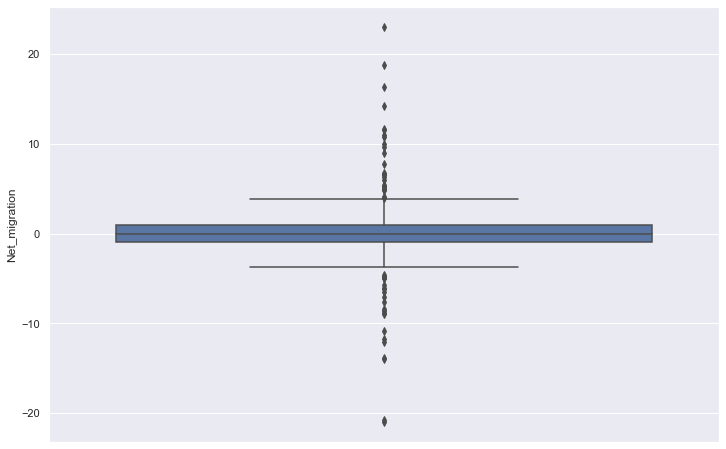

In [242]:
sns.boxplot(countries['Net_migration'], orient="vertical")

In [344]:
quantile_1 = countries['Net_migration'].quantile(0.25)
quantile_3 = countries['Net_migration'].quantile(0.75)
iqr = quantile_3 - quantile_1

non_outlier_interval_iqr = [quantile_1 - 1.5 * iqr, quantile_3 + 1.5 * iqr]

print(f"Faixa considerada \"normal\": {non_outlier_interval_iqr}")

Faixa considerada "normal": [-3.8149999999999995, 3.885]


In [345]:
outliers_above = countries['Net_migration'][(countries['Net_migration'] > non_outlier_interval_iqr[1])]
outliers_below = countries['Net_migration'][(countries['Net_migration'] < non_outlier_interval_iqr[0])]

In [346]:
def q5():
    # Retorne aqui o resultado da questão 4.
    return (int(len(outliers_below)), int(len(outliers_above)), False)

In [347]:
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [254]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

In [274]:
print("Total de documentos ",len(newsgroup.data))

Total de documentos  1773


In [256]:
count_vectorizer = CountVectorizer()
newsgroups_counts = count_vectorizer.fit_transform(newsgroup.data)

In [276]:
print("Vocabulário ",len(count_vectorizer.vocabulary_), " palavras")

Vocabulário  27335  palavras


In [277]:
index_phone = count_vectorizer.vocabulary_.get('phone')

In [278]:
def q6():
    # Retorne aqui o resultado da questão 4.
    return int(sum(newsgroups_counts[:, index_phone].toarray())[0])

In [279]:
q6()

213

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [281]:
tfidf_vectorizer = TfidfVectorizer()

newsgroups_tfidf_vectorized = tfidf_vectorizer.fit_transform(newsgroup.data)

In [292]:
newsgroups_tfidf_vectorized.shape

(1773, 27335)

In [295]:
index_phone_tfidf = tfidf_vectorizer.vocabulary_['phone']

In [310]:
newsgroups_tfidf_vectorized[newsgroups_tfidf_vectorized[:, index_phone_tfidf].toarray() > 0][0]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00355054, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00611586, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00427282, 0.        , 0.04316673,
         0.        , 0.0611656 , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.14963541, 0.        , 0.00783287, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [321]:
round(newsgroups_tfidf_vectorized[:, index_phone_tfidf].toarray().sum(), 3)

8.888

In [319]:
def q7():
    # Retorne aqui o resultado da questão 4.
    return float(round(newsgroups_tfidf_vectorized[:, index_phone_tfidf].toarray().sum(), 3))

In [320]:
q7()

8.888